['warcraft', 'map1', 'random', 'seed2']
['warcraft', 'map1', 'tpe', 'seed5']
['warcraft', 'map3', 'tpe', 'seed6']
['warcraft', 'map3', 'random', 'seed4']
['warcraft', 'map2', 'tpe', 'seed3']
['warcraft', 'map1', 'random', 'seed6']
['warcraft', 'map1', 'tpe', 'seed1']
['warcraft', 'map3', 'tpe', 'seed2']
['warcraft', 'map3', 'random', 'seed0']
['warcraft', 'map2', 'tpe', 'seed7']
['warcraft', 'map1', 'random', 'seed7']
['warcraft', 'map1', 'tpe', 'seed0']
['warcraft', 'map3', 'tpe', 'seed3']
['warcraft', 'map3', 'random', 'seed1']
['warcraft', 'map2', 'tpe', 'seed6']
['warcraft', 'map1', 'random', 'seed3']
['warcraft', 'map1', 'tpe', 'seed4']
['warcraft', 'map3', 'tpe', 'seed7']
['warcraft', 'map3', 'random', 'seed5']
['warcraft', 'map2', 'tpe', 'seed2']
['warcraft', 'map1', 'random', 'seed8']
['warcraft', 'map2', 'tpe', 'seed9']
['warcraft', 'map2', 'random', 'seed1']
['warcraft', 'map3', 'tpe', 'seed8']
['warcraft', 'map2', 'random', 'seed5']
['warcraft', 'map3', 'tpe', 'seed9']
['war

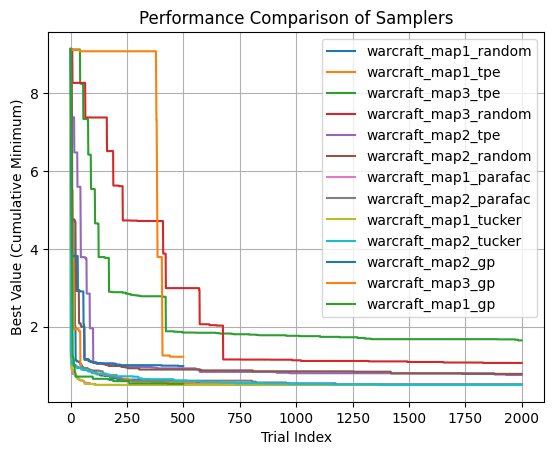

In [1]:
import os
import optuna
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ディレクトリを指定
results_dir = "/Users/keisukeonoue/ws/constrained_BO_v3/results_constrained"

# {目的関数}_{サンプラー} -> [各シードの最適値履歴] を格納
results = defaultdict(list)

# DB ファイルを探索
for root, _, files in os.walk(results_dir):
    for file in files:
        if file.endswith(".db"):
            db_path = os.path.join(root, file)
            # ルートディレクトリ名を取得
            root_dir = os.path.basename(os.path.dirname(root))
            # study_name を修正
            study_name = f"{root_dir}_{file[:-3]}"
            
            # ファイル名を分解
            file_parts = file[:-3].split("_")

            print(file_parts)

            objective_function, sampler, seed = f"{file_parts[0]}_{file_parts[1]}", file_parts[2], file_parts[3]

            # study を読み込み
            study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{db_path}")

            # トライアル時点での最適値履歴を取得
            trials = study.trials
            values = np.array([t.value for t in trials if t.value is not None])
            cummin_values = np.minimum.accumulate(values)

            # {目的関数}_{サンプラー} ごとに結果を追加
            key = f"{objective_function}_{sampler}"
            results[key].append(cummin_values)

# グラフをプロット
for objective_sampler, histories in results.items():
    # 各シードの履歴を平均
    max_length = max(len(h) for h in histories)
    padded_histories = [np.pad(h, (0, max_length - len(h)), 'edge') for h in histories]
    mean_history = np.mean(padded_histories, axis=0)

    # プロット
    plt.plot(mean_history, label=objective_sampler)

# グラフの設定
plt.xlabel("Trial Index")
plt.ylabel("Best Value (Cumulative Minimum)")
plt.title("Performance Comparison of Samplers")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import plotly.graph_objects as go

# 分類のためのヘルパー関数
def group_keys_by_objective(results_keys):
    grouped = defaultdict(list)
    for key in results_keys:
        objective_function = "_".join(key.split("_")[:2])  # 例: "ackley_dim2"
        grouped[objective_function].append(key)
    return grouped

# Keys を分類
grouped_results = group_keys_by_objective(sorted(results.keys()))
grouped_results

defaultdict(list,
            {'warcraft_map1': ['warcraft_map1_gp',
              'warcraft_map1_parafac',
              'warcraft_map1_random',
              'warcraft_map1_tpe',
              'warcraft_map1_tucker'],
             'warcraft_map2': ['warcraft_map2_gp',
              'warcraft_map2_parafac',
              'warcraft_map2_random',
              'warcraft_map2_tpe',
              'warcraft_map2_tucker'],
             'warcraft_map3': ['warcraft_map3_gp',
              'warcraft_map3_random',
              'warcraft_map3_tpe']})

# max 500

In [6]:
import plotly.colors as pc
import plotly.graph_objects as go
from collections import defaultdict
import numpy as np

max_plot_length = 500

# Function to convert hex to rgba
def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})'

# Updating sampler colors to HEX for compatibility
sampler_colors = {
    'random': pc.qualitative.Plotly[0],
    'tpe': pc.qualitative.Plotly[1],
    'gp': pc.qualitative.Plotly[2],
    'parafac': pc.qualitative.Plotly[3],
    'tucker': pc.qualitative.Plotly[4],
}

for objective_function, samplers in grouped_results.items():
    fig = go.Figure()
    
    if "warcraft_map3" == objective_function:
        continue

    # if "parafac" not in [sampler_key.split("_")[2] for sampler_key in samplers]:
    #     continue

    for sampler_key in samplers:
        # サンプラーを抽出
        sampler_name = sampler_key.split("_")[2]  # "random", "tpe", etc.

        # 各サンプラーの結果をプロット
        histories = results[sampler_key]
        max_length = max(len(h) for h in histories)
        padded_histories = [np.pad(h, (0, max_length - len(h)), 'edge') for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)

        # プロットする範囲を制限
        truncated_mean_history = mean_history[:max_plot_length]
        truncated_std_history = std_history[:max_plot_length]

        # 1シグマの上下限を計算
        lower_bound = truncated_mean_history - truncated_std_history
        upper_bound = truncated_mean_history + truncated_std_history

        # 平均履歴をプロット
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))),
            y=truncated_mean_history,
            mode='lines',
            name=sampler_name,
            line=dict(color=sampler_colors[sampler_name])
        ))

                # 1シグマの塗りつぶしを追加
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))) + list(range(len(truncated_mean_history))[::-1]),
            y=list(upper_bound) + list(lower_bound[::-1]),
            fill='toself',
            fillcolor=hex_to_rgba(sampler_colors[sampler_name], alpha=0.2),
            line=dict(color='rgba(255,255,255,0)'),  # No border line
            hoverinfo="skip",  # Skip hover info for the fill
            showlegend=False  # Don't show in the legend
        ))


    # グラフの設定
    fig.update_layout(
        title=f"Performance Comparison for {objective_function}",
        xaxis_title="Trial Index",
        yaxis_title="Best Value (Cumulative Minimum)",
        legend_title="Sampler",
        template="plotly_white"
    )
    fig.show()

    
    import os
    file_name = os.path.join(results_dir, f"{objective_function}_history.png")
    fig.write_image(file_name)


In [7]:
import plotly.colors as pc
import plotly.graph_objects as go
from collections import defaultdict
import numpy as np

max_plot_length = 500

# Function to convert hex to rgba
def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})'

# Updating sampler colors to HEX for compatibility
sampler_colors = {
    'random': pc.qualitative.Plotly[0],
    'tpe': pc.qualitative.Plotly[1],
    'gp': pc.qualitative.Plotly[2],
    'parafac': pc.qualitative.Plotly[3],
    'tucker': pc.qualitative.Plotly[4],
}

for objective_function, samplers in grouped_results.items():
    fig = go.Figure()
    
    if "warcraft_map3" == objective_function:
        continue

    for sampler_key in samplers:
        # Extract sampler name
        sampler_name = sampler_key.split("_")[2]  # "random", "tpe", etc.

        # Plot results for each sampler
        histories = results[sampler_key]
        max_length = max(len(h) for h in histories)
        padded_histories = [np.pad(h, (0, max_length - len(h)), 'edge') for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)

        # Limit plotting range
        truncated_mean_history = mean_history[:max_plot_length]
        truncated_std_history = std_history[:max_plot_length]

        # Calculate 1-sigma bounds
        lower_bound = truncated_mean_history - truncated_std_history
        upper_bound = truncated_mean_history + truncated_std_history

        # Plot mean history
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))),
            y=truncated_mean_history,
            mode='lines',
            name=sampler_name,
            line=dict(color=sampler_colors[sampler_name])
        ))

        # Add 1-sigma fill
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))) + list(range(len(truncated_mean_history))[::-1]),
            y=list(upper_bound) + list(lower_bound[::-1]),
            fill='toself',
            fillcolor=hex_to_rgba(sampler_colors[sampler_name], alpha=0.2),
            line=dict(color='rgba(255,255,255,0)'),  # No border line
            hoverinfo="skip",  # Skip hover info for the fill
            showlegend=False  # Don't show in the legend
        ))

    # Update graph layout with log scale for y-axis
    fig.update_layout(
        title=f"Performance Comparison for {objective_function}",
        xaxis_title="Trial Index",
        yaxis_title="Best Value (Cumulative Minimum)",
        legend_title="Sampler",
        template="plotly_white",
        yaxis=dict(
            type='log',  # Set y-axis to log scale
            title="Best Value (Log Scale)"  # Update y-axis title to reflect log scale
        )
    )
    fig.show()

    # Save figure as image
    import os
    file_name = os.path.join(results_dir, f"{objective_function}_history.png")
    fig.write_image(file_name)


# max 2000

In [8]:
import plotly.colors as pc
import plotly.graph_objects as go
from collections import defaultdict
import numpy as np

max_plot_length = 2000

# Function to convert hex to rgba
def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})'

# Updating sampler colors to HEX for compatibility
sampler_colors = {
    'random': pc.qualitative.Plotly[0],
    'tpe': pc.qualitative.Plotly[1],
    'gp': pc.qualitative.Plotly[2],
    'parafac': pc.qualitative.Plotly[3],
    'tucker': pc.qualitative.Plotly[4],
}

for objective_function, samplers in grouped_results.items():
    fig = go.Figure()
    
    if "warcraft_map3" == objective_function:
        continue

    # if "parafac" not in [sampler_key.split("_")[2] for sampler_key in samplers]:
    #     continue

    for sampler_key in samplers:
        # サンプラーを抽出
        sampler_name = sampler_key.split("_")[2]  # "random", "tpe", etc.

        # 各サンプラーの結果をプロット
        histories = results[sampler_key]
        max_length = max(len(h) for h in histories)
        padded_histories = [np.pad(h, (0, max_length - len(h)), 'edge') for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)

        # プロットする範囲を制限
        truncated_mean_history = mean_history[:max_plot_length]
        truncated_std_history = std_history[:max_plot_length]

        # 1シグマの上下限を計算
        lower_bound = truncated_mean_history - truncated_std_history
        upper_bound = truncated_mean_history + truncated_std_history

        # 平均履歴をプロット
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))),
            y=truncated_mean_history,
            mode='lines',
            name=sampler_name,
            line=dict(color=sampler_colors[sampler_name])
        ))

                # 1シグマの塗りつぶしを追加
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))) + list(range(len(truncated_mean_history))[::-1]),
            y=list(upper_bound) + list(lower_bound[::-1]),
            fill='toself',
            fillcolor=hex_to_rgba(sampler_colors[sampler_name], alpha=0.2),
            line=dict(color='rgba(255,255,255,0)'),  # No border line
            hoverinfo="skip",  # Skip hover info for the fill
            showlegend=False  # Don't show in the legend
        ))


    # グラフの設定
    fig.update_layout(
        title=f"Performance Comparison for {objective_function}",
        xaxis_title="Trial Index",
        yaxis_title="Best Value (Cumulative Minimum)",
        legend_title="Sampler",
        template="plotly_white"
    )
    fig.show()

    
    import os
    file_name = os.path.join(results_dir, f"{objective_function}_history.png")
    fig.write_image(file_name)


In [9]:
import plotly.colors as pc
import plotly.graph_objects as go
from collections import defaultdict
import numpy as np

max_plot_length = 2000

# Function to convert hex to rgba
def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})'

# Updating sampler colors to HEX for compatibility
sampler_colors = {
    'random': pc.qualitative.Plotly[0],
    'tpe': pc.qualitative.Plotly[1],
    'gp': pc.qualitative.Plotly[2],
    'parafac': pc.qualitative.Plotly[3],
    'tucker': pc.qualitative.Plotly[4],
}

for objective_function, samplers in grouped_results.items():
    fig = go.Figure()
    
    if "warcraft_map3" == objective_function:
        continue

    for sampler_key in samplers:
        # Extract sampler name
        sampler_name = sampler_key.split("_")[2]  # "random", "tpe", etc.

        # Plot results for each sampler
        histories = results[sampler_key]
        max_length = max(len(h) for h in histories)
        padded_histories = [np.pad(h, (0, max_length - len(h)), 'edge') for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)

        # Limit plotting range
        truncated_mean_history = mean_history[:max_plot_length]
        truncated_std_history = std_history[:max_plot_length]

        # Calculate 1-sigma bounds
        lower_bound = truncated_mean_history - truncated_std_history
        upper_bound = truncated_mean_history + truncated_std_history

        # Plot mean history
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))),
            y=truncated_mean_history,
            mode='lines',
            name=sampler_name,
            line=dict(color=sampler_colors[sampler_name])
        ))

        # Add 1-sigma fill
        fig.add_trace(go.Scatter(
            x=list(range(len(truncated_mean_history))) + list(range(len(truncated_mean_history))[::-1]),
            y=list(upper_bound) + list(lower_bound[::-1]),
            fill='toself',
            fillcolor=hex_to_rgba(sampler_colors[sampler_name], alpha=0.2),
            line=dict(color='rgba(255,255,255,0)'),  # No border line
            hoverinfo="skip",  # Skip hover info for the fill
            showlegend=False  # Don't show in the legend
        ))

    # Update graph layout with log scale for y-axis
    fig.update_layout(
        title=f"Performance Comparison for {objective_function}",
        xaxis_title="Trial Index",
        yaxis_title="Best Value (Cumulative Minimum)",
        legend_title="Sampler",
        template="plotly_white",
        yaxis=dict(
            type='log',  # Set y-axis to log scale
            title="Best Value (Log Scale)"  # Update y-axis title to reflect log scale
        )
    )
    fig.show()

    # Save figure as image
    import os
    file_name = os.path.join(results_dir, f"{objective_function}_history.png")
    fig.write_image(file_name)
